In [2]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, LogFormatter, FuncFormatter

from Functions import *
import MetricMapping

# Access the mappings:
type_mapping = MetricMapping.type_mapping
name_mapping = MetricMapping.name_mapping

## Prepare the data
### Get the data

In [6]:
transformed_minmax_scaled = pd.read_csv("../Data/NotScaled_RawVsDMC.csv")

transformed_minmax_scaled['peak_mean_ratio_DMC_10'] = transformed_minmax_scaled['peak_mean_ratio_scaled_DMC_10']
transformed_minmax_scaled['relative_amp_DMC_10'] = transformed_minmax_scaled['relative_amp_scaled_DMC_10']
transformed_minmax_scaled['peak_mean_ratio'] = transformed_minmax_scaled['peak_mean_ratio_scaled']
transformed_minmax_scaled['relative_amp'] = transformed_minmax_scaled['relative_amp_scaled']

cols_to_delete = ['relative_amp_scaled', 'relative_amp_scaled_DMC_10',
    'peak_mean_ratio_scaled', 'peak_mean_ratio_scaled_DMC_10','min_intensity', 'min_intensity_DMC_10',
     'm1_DMC_10', 'm2_DMC_10', 'm3_DMC_10','m4_DMC_10', 'm5_DMC_10']

for col in cols_to_delete:
    del transformed_minmax_scaled[col]

column_names=transformed_minmax_scaled.columns

### Get a list of metrics

In [7]:
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in column_names if metric not in categorical_metrics]
intermittency_metrics = ['intermittency', 'event_dry_ratio']

metric_base_names = {col.replace(suffix, '') for col in transformed_minmax_scaled.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

### Calculate statistics on the data

In [9]:
summary_df = compute_metric_sensitivity_bynormalisation(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics)
summary_df["type2"] = summary_df["metric"].map(type_mapping)

# Sort by type_2 and descending rank_corr
summary_df = summary_df.sort_values(
    by=["type2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type2" else -col))

### Get versions of the data split by metric type`

In [10]:
df_intermittency = summary_df[summary_df["type2"] == "Intermittency"]
df_other = summary_df[(summary_df["type2"] != "Intermittency") & (summary_df["type"] != "categorical")]
df_categorical = summary_df[summary_df["type"] == "categorical"]
df_continuous =  pd.concat([df_other, df_intermittency])

## Plotting
### Scatter plot

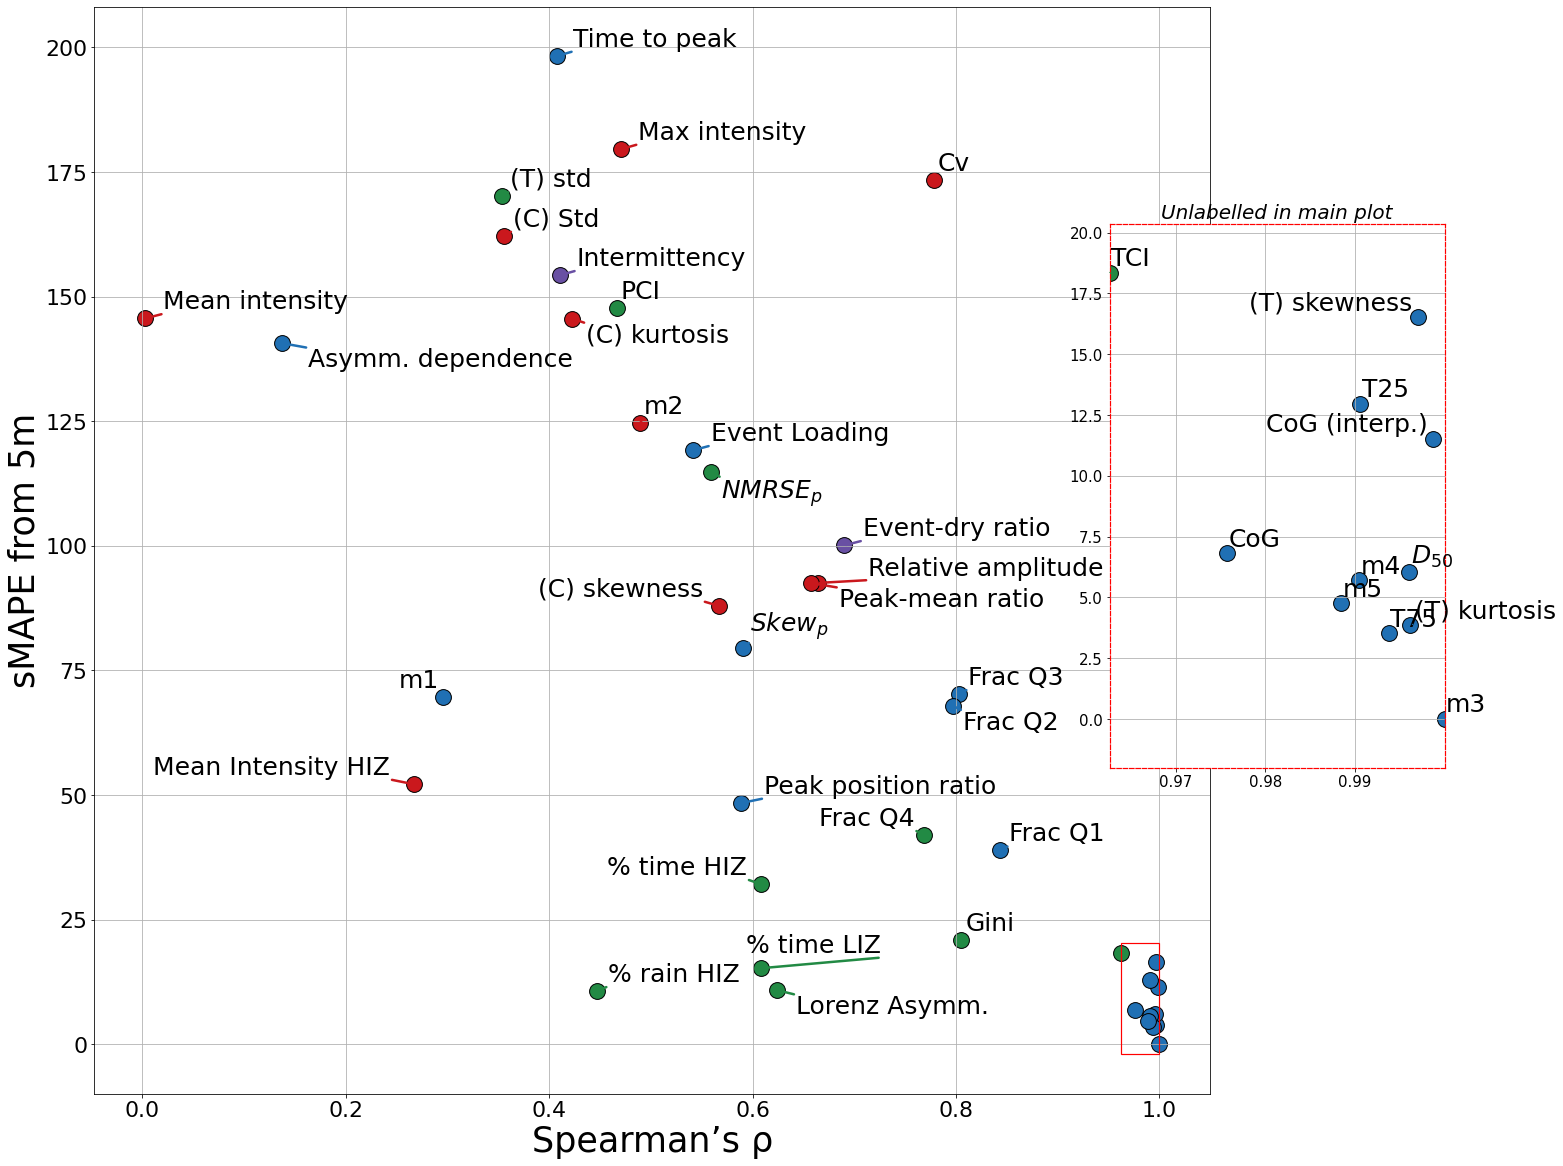

In [11]:
size=250
labelsize = 25
texts = []
face_colors = []
original_positions = []
marker = 'o'

# Determine which points to label
mask_label = ~((df_continuous["rank_corr"] > 0.96) & (df_continuous["val_diff"] < 25))
df_label = df_continuous[mask_label]
df_skip = df_continuous[~mask_label]

fig, ax = plt.subplots(figsize=(20, 20))

# --- Main plot: plot all points ---
for _, row in df_continuous.iterrows():
    face_color = type_color_map_2[row['type2']][2]
    ax.scatter(row["rank_corr"], row["val_diff"],facecolor=face_color,edgecolor='black',marker=marker,s=size, alpha=1)
ax.tick_params(axis='both', which='major', labelsize=22)

# --- Add labels to selected points ---
for _, row in df_label.iterrows():
    face_color = type_color_map_2[row['type2']][2]
    original_positions.append((row["rank_corr"], row["val_diff"]))
    face_colors.append(face_color)
    
    txt = ax.text(row["rank_corr"], row["val_diff"],name_mapping[row["metric"]],
                  fontsize=labelsize, color='black')
    texts.append(txt)

# --- Adjust labels ---
adjust_text(
    texts, ax=ax,
    arrowprops=None,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'xy', 'text': 'xy'},
    force_points=0.2,
    force_text=0.2,
)

# --- Draw colored arrows ---
for txt, (x0, y0), face_color in zip(texts, original_positions, face_colors):
    x1, y1 = txt.get_position()
    ax.annotate("",
        xy=(x0, y0), xytext=(x1, y1),
        arrowprops=dict(arrowstyle='-', color=face_color, lw=2.5))

# --- Inset plot for skipped labels ---
ax_inset = inset_axes(
    ax,
    width="30%", height="50%",
    loc='upper left',
    bbox_to_anchor=(0.91, -0.2, 1, 1),  # Shifted to the right of ax
    bbox_transform=ax.transAxes,
    borderpad=0.0)


# Make the inset axes border red to match the rectangle
for spine in ax_inset.spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(1.2)
    spine.set_linestyle('--')

texts_inset = []
positions_inset = []
face_colors_inset = []

for _, row in df_skip.iterrows():
    face_color = type_color_map_2[row['type2']][2]
    ax_inset.scatter(
        row["rank_corr"], row["val_diff"],
        facecolor=face_color,
        edgecolor='black',
        marker=marker,
        s=size * 1,
        alpha=1
    )
    positions_inset.append((row["rank_corr"], row["val_diff"]))
    face_colors_inset.append(face_color)
    
    txt = ax_inset.text(
        row["rank_corr"], row["val_diff"],name_mapping[row["metric"]],
        fontsize=labelsize * 1, color='black'
    )
    texts_inset.append(txt)

# Adjust inset labels to avoid overlaps
adjust_text(
    texts_inset, ax=ax_inset,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'xy', 'text': 'xy'},
    force_points=0.1,
    force_text=0.1,
    arrowprops=None)

# Optionally: colored arrows in inset
for txt, (x0, y0), face_color in zip(texts_inset, positions_inset, face_colors_inset):
    x1, y1 = txt.get_position()
    ax_inset.annotate("",
        xy=(x0, y0), xytext=(x1, y1),
        arrowprops=dict(arrowstyle='-', color=face_color, lw=1))
    
# Tidy inset plot
ax_inset.set_title("Unlabelled in main plot", fontsize=20, fontstyle="italic")
ax_inset.tick_params(labelsize=5)
ax_inset.grid(True)

# Match inset limits for spatial consistency
ax_inset.set_xlim(df_skip["rank_corr"].min(), df_skip["rank_corr"].max())
ax_inset.set_ylim(df_skip["val_diff"].min() - 2, df_skip["val_diff"].max() + 2)

# --- Main axes setup ---
ax.set_xlabel("Spearman’s ρ", fontsize=35)
ax.set_ylabel("sMAPE from 5m", fontsize=35)
ax.grid(True)

ax_inset.tick_params(axis='both', which='major', labelsize=15)

# Coordinates & size of inset zoom region (same as inset x/y limits)
x0, x1 = ax_inset.get_xlim()
y0, y1 = ax_inset.get_ylim()

# Create a rectangle patch
rect = patches.Rectangle(
    (x0, y0),         # bottom-left corner
    x1 - x0,          # width
    y1 - y0,          # height
    linewidth=1.2,
    edgecolor='red',  # color of the box outline
    facecolor='none', # transparent fill
    linestyle='-',
    zorder=5          # draw on top
)

# Add the rectangle to the main axes
ax.add_patch(rect)

# Define corners of rectangle
corners = [(x0, y0), (x0, y1), (x1, y1), (x1, y0)]
# Define corresponding corners in inset axes (in data coords)
inset_corners = [
    (ax_inset.get_xlim()[0], ax_inset.get_ylim()[0]),
    (ax_inset.get_xlim()[0], ax_inset.get_ylim()[1]),
    (ax_inset.get_xlim()[1], ax_inset.get_ylim()[1]),
    (ax_inset.get_xlim()[1], ax_inset.get_ylim()[0])]

for (x_main, y_main), (x_in, y_in) in zip(corners, inset_corners):
    line = Line2D([x_main, x_in], [y_main, y_in],
                  transform=ax.transData,
                  color='red', linestyle='--', linewidth=2)
    fig.add_artist(line)

# plt.tight_layout()
plt.show()
fig.savefig("../Figures/Scatter_continuous_DMC10.png", dpi=300, facecolor='white', bbox_inches='tight')

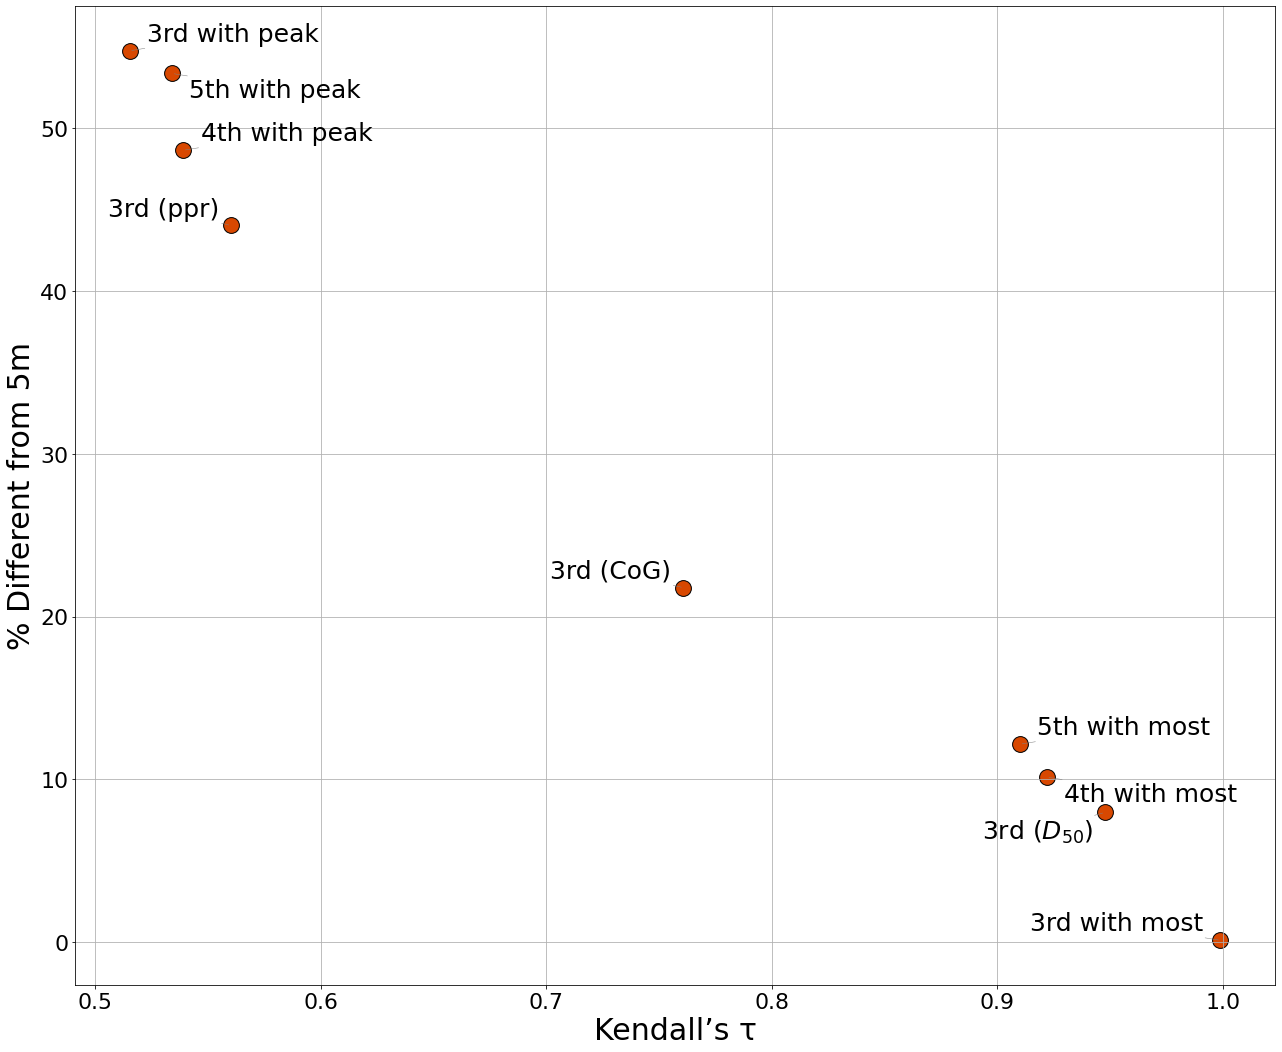

In [14]:
fig, ax = plt.subplots(figsize=(21.5, 18))  # Expanded canvas

marker = 'o'
size = 250
labelsize = 25
texts = []

for _, row in df_categorical.iterrows():
    # Scatter point
    ax.scatter(
        row["rank_corr"],
        row["val_diff"],
        facecolor=type_color_map_2[row['type']][2],
        edgecolor='black',
        marker=marker,
        s=size,
        alpha=1)
    # Clean label name
    metric_name = name_mapping[row["metric"]]
    
    # Create text object (to be adjusted later)
    texts.append(
        ax.text(row["rank_corr"], row["val_diff"], metric_name, fontsize=labelsize))
ax.tick_params(axis='both', which='major', labelsize=22)
# Axes labels
ax.set_xlabel("Kendall’s τ", fontsize=30)
ax.set_ylabel("% Different from 5m", fontsize=30)
ax.grid(True)
# Adjust text to avoid overlaps
adjust_text(texts,
     ax=ax,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'xy', 'text': 'xy'},
    force_points=0.5,
    force_text=1.2)

fig.savefig("../Figures/Scatter_categorical_DMC10.png", dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
# # Labels and corresponding colors (replace with your actual colors if different)
# labels = ['Asymmetry', 'Peakiness', 'Concentration', 'Intermittency', 'Categorical']
# face_colors = []
# for thetype in ['Asymmetry', "Peakiness", "Concentration", "Intermittency", "Categorical"]:
#     face_color = type_color_map_2[thetype][2]
#     face_colors.append(face_color)


# # Create legend handles
# handles = [
#     plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=21, linestyle='')
#     for color in face_colors]

# # Create figure and plot only the legend
# fig, ax = plt.subplots(figsize=(5, 2))
# legend = ax.legend(
#     handles,
#     labels,
# #     title='Metric Type',
#     ncol=len(labels),
#     loc='center',
#     frameon=False
# )
# ax.axis('off')

# fig.savefig("../Figures/legend_for_DMC_Scatter.png", bbox_inches='tight', dpi=300, facecolor='white')
# plt.tight_layout()
# plt.show()


### Plot histograms

In [ ]:
# resolutions = ['', '_DMC_10']

In [15]:
def plot_histogram_log (data, color,log_shared_bins, ax):
#     min_val = max(min(data), 1e-3)
#     max_val = max(data)

#     log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
#     log_bins = np.unique(log_bins)
    
    # ax.hist(data, bins=log_bins, alpha=0.5, label='Mean Intensity', color=color)
    sns.histplot(data, bins=log_shared_bins, kde=False, ax=ax, color=color, element='step',stat='count', fill=True,alpha=0.5)    

def plot_histogram(data, color,linear_shared_bins, ax):
#     bins=20
    sns.histplot(data, bins=linear_shared_bins, kde=False, ax=ax, color=color, element='step',stat='density', fill=True,alpha=0.5)    
    #ax.hist(data, bins=bins, alpha=0.5, label='Mean Intensity', color=color, element='step',stat='density',)

In [ ]:
# fig,ax=plt.subplots()
# this_metric='peak_mean_ratio'
# this_metric_data = transformed_minmax_scaled[this_metric]
# this_metric_data_DMC = transformed_minmax_scaled[this_metric + '_DMC_10']

# this_metric_data = this_metric_data.dropna().values
# this_metric_data = this_metric_data[this_metric_data > 0]
# this_metric_data_DMC = this_metric_data_DMC.dropna().values
# this_metric_data_DMC = this_metric_data_DMC[this_metric_data_DMC > 0]
    
# log_shared_bins = np.logspace(np.log10(all_values.min()), np.log10(all_values.max()), 35)
# print(log_shared_bins)
# plot_histogram_log(this_metric_data, color_map[0],log_shared_bins, ax)
# plot_histogram_log(this_metric_data_DMC, color_map[1], log_shared_bins, ax)
# ax.set_xscale('log')  # now this matches your binning
# ax.set_xscale('log')
# ax.xaxis.set_major_formatter(FuncFormatter(
#     lambda x, _: f"{x:.3f}".rstrip("0").rstrip(".") if x < 1 else f"{x:.0f}"))

# print(f"Min: {all_values.min()}, Max: {all_values.max()}")

In [16]:
log_scale_metrics = ['mean_intensity', 'time_to_peak', 'std', 'Mean Intensity HIZ', 'm1', 'm1_wi', 'cv', 'time_kurtosis',
                    'max_intensity', 'mean_intensity', 'kurtosis', 'relative_amp', 'peak_mean_ratio', 'Event Loading',
                    'PCI', 'time_std']

In [17]:
def decimal_formatter(x, pos):
    if x < 1:
        return f"{x:.3f}".rstrip('0').rstrip('.')
    else:
        return f"{x:.0f}"

NameError: name 'x' is not defined

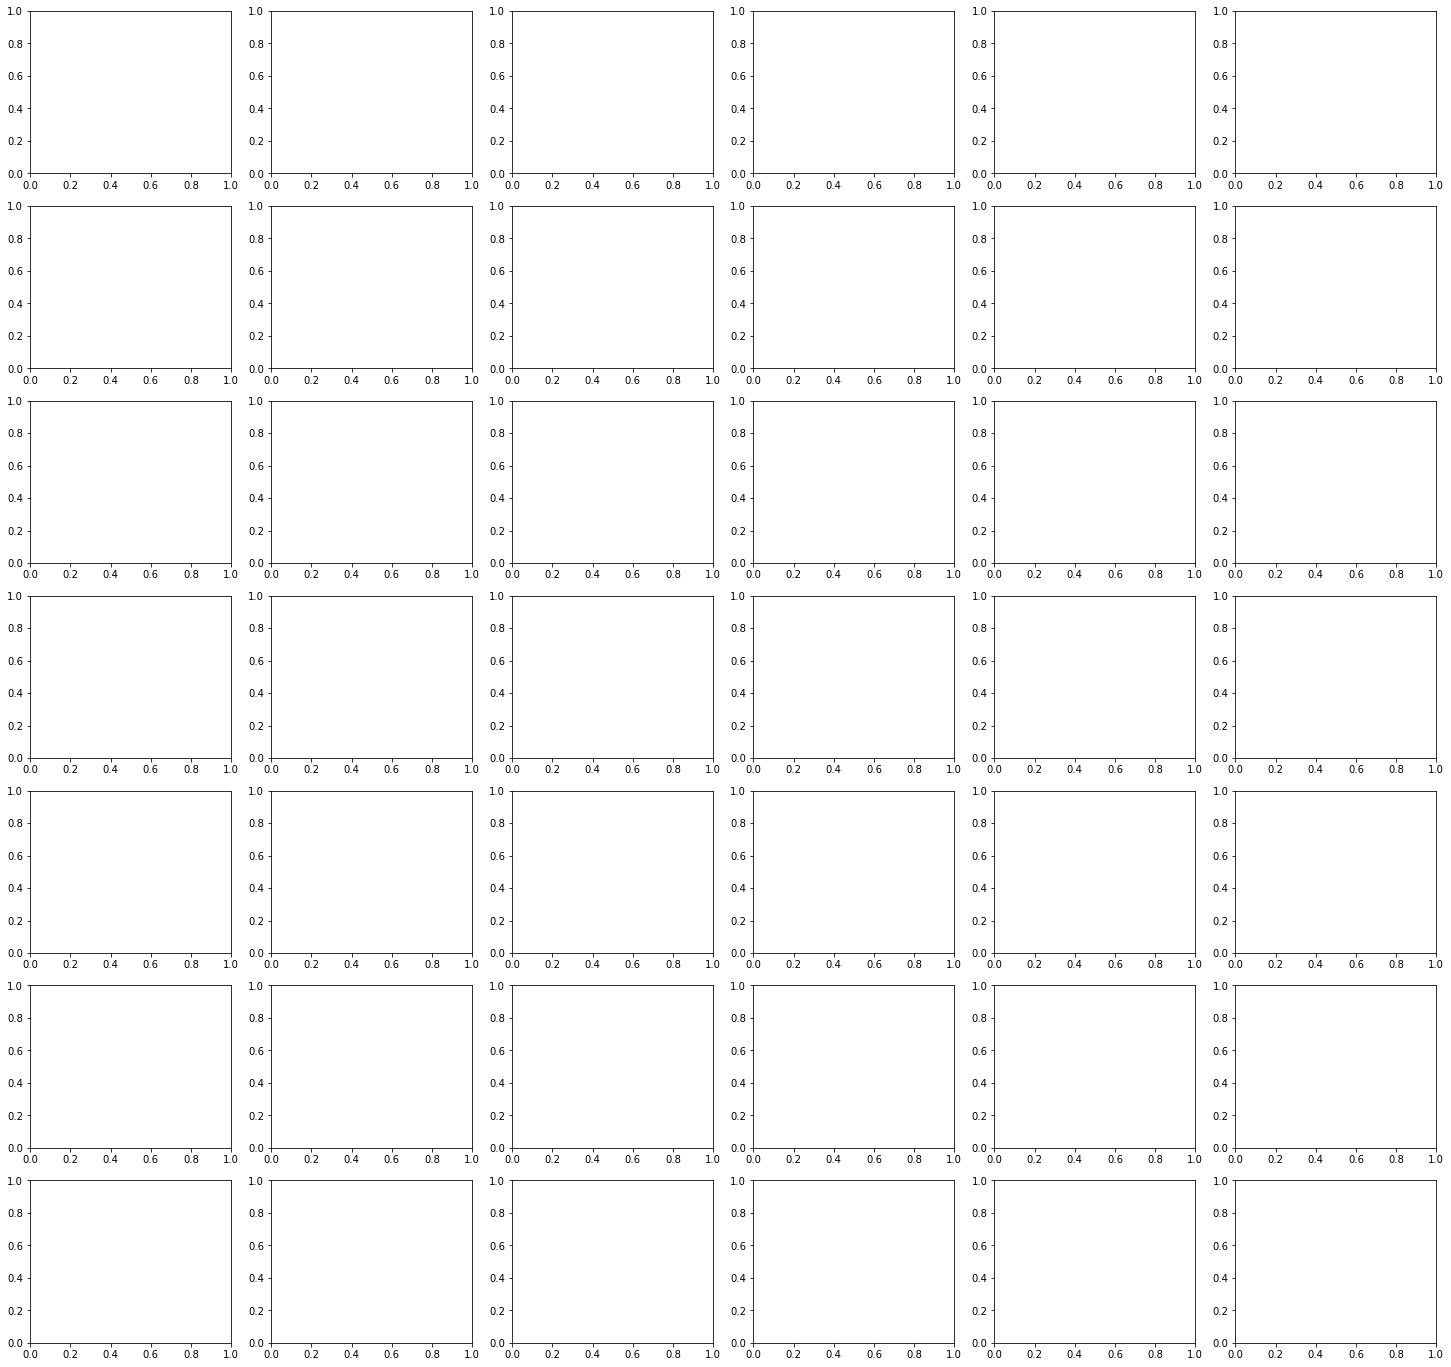

In [19]:
unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

for i, this_metric in enumerate(unique_metrics_main):
    ## Get the data, raw and DMC
    this_metric_data = transformed_minmax_scaled[this_metric]
    this_metric_data_DMC = transformed_minmax_scaled[this_metric + '_DMC_10']
    
    #################################
    ## Create shared bins
    #################################
    # Drop NaNs if necessary
    this_metric_data = this_metric_data.dropna().values
    this_metric_data = this_metric_data[this_metric_data > 0]
    this_metric_data_DMC = this_metric_data_DMC.dropna().values
    this_metric_data_DMC = this_metric_data_DMC[this_metric_data_DMC > 0]
    
    # Combine to find the global min and max
    all_data = np.concatenate([x, y])
    bin_min = np.min(all_data)
    bin_max = np.max(all_data)

    # Create shared bin edges
    n_bins = 20
    shared_bins = np.linspace(bin_min, bin_max, n_bins + 1)
    
    #################################
    ## Get plotting colours
    #################################   
    metric_type = type_mapping[this_metric]
    # print(this_metric, metric_type)
    color_map = type_color_map[metric_type]
    
    ax = axs_main[i]
    
    #################################
    ## Plot
    #################################   
    if this_metric == 'mean_intensity':
        ax.axvline(x=0.1, color=color_map[1], linestyle='solid', alpha=0.5,linewidth=4, label='DMC 10 value = 0.1')
        plot_histogram(this_metric_data,color_map[0], linear_shared_bins, ax) 
        
    else:
        if this_metric in log_scale_metrics:
            all_values = np.concatenate([this_metric_data, this_metric_data_DMC])
            log_shared_bins = np.logspace(np.log10(all_values.min()), np.log10(all_values.max()), 35)
            plot_histogram_log(this_metric_data, color_map[0],log_shared_bins, ax)
            plot_histogram_log(this_metric_data_DMC, color_map[1], log_shared_bins, ax)
            ax.set_xscale('log')
            ax.xaxis.set_major_formatter(FuncFormatter(
                lambda x, _: f"{x:.3f}".rstrip("0").rstrip(".") if x < 1 else f"{x:.0f}"))
    
        else:
            all_values = np.concatenate([this_metric_data, this_metric_data_DMC])
            linear_shared_bins = np.linspace(all_values.min(), all_values.max(), 30)
            plot_histogram(this_metric_data,color_map[0], linear_shared_bins, ax)        
            plot_histogram(this_metric_data_DMC,color_map[1], linear_shared_bins, ax) 
    
    title = name_mapping.get(this_metric, this_metric)
    ax.set_title(title, fontsize=25, fontstyle="italic")
    ax.tick_params(axis='both', labelsize=15)    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid('on')
    
for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("../Figures/histograms_main_DMC10.png", dpi=300, facecolor='white')


In [ ]:
unique_metrics_main = df_intermittency["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

for i, this_metric in enumerate(unique_metrics_main):
    ## Get the data, raw and DMC
    this_metric_data = transformed_minmax_scaled[this_metric]
    this_metric_data_DMC = transformed_minmax_scaled[this_metric + '_DMC_10']
    
    #################################
    ## Create shared bins
    #################################
    # Drop NaNs if necessary
    this_metric_data = this_metric_data.dropna().values
    this_metric_data = this_metric_data[this_metric_data > 0]
    this_metric_data_DMC = this_metric_data_DMC.dropna().values
    this_metric_data_DMC = this_metric_data_DMC[this_metric_data_DMC > 0]
    
    # Combine to find the global min and max
    all_data = np.concatenate([x, y])
    bin_min = np.min(all_data)
    bin_max = np.max(all_data)

    # Create shared bin edges
    n_bins = 20
    shared_bins = np.linspace(bin_min, bin_max, n_bins + 1)
    
    #################################
    ## Get plotting colours
    #################################   
    metric_type = type_mapping[this_metric]
    color_map = type_color_map[metric_type]
    
    ax = axs_main[i]
    
    #################################
    ## Plot
    #################################   
    if this_metric == 'mean_intensity':
        ax.axvline(x=0.1, color=color_map[1], linestyle='--', linewidth=2, label='DMC 10 value = 0.1')
        plot_histogram(this_metric_data,color_map[0], linear_shared_bins, ax) 
        
    else:
        all_values = np.concatenate([this_metric_data, this_metric_data_DMC])
        linear_shared_bins = np.linspace(all_values.min(), all_values.max(), 30)
        plot_histogram(this_metric_data,color_map[0], linear_shared_bins, ax)        
        plot_histogram(this_metric_data_DMC,color_map[1], linear_shared_bins, ax) 
    
    title = name_mapping.get(this_metric, this_metric)
    ax.set_title(title, fontsize=25, fontstyle="italic")
    ax.tick_params(axis='both', labelsize=15)    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("../Figures/histograms_intermittency_DMC10.png", dpi=300, facecolor='white')